In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pickle
import warnings

In [2]:

warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv('UNSW_NB15_training-set.csv')

In [4]:
# Drop the 'id' column
df = df.drop(columns=['id'])

In [5]:
# Handle missing values
df = df.dropna()

In [6]:
# Reduce the dataset size by 90%
df, _ = train_test_split(df, test_size=0.5, random_state=42)

In [7]:
# Define the features (X) and target (y)
X = df.drop(columns=['attack_cat'])
y = df['attack_cat']

In [8]:
# Identify categorical columns for one-hot encoding
categorical_cols = ['proto', 'service', 'state']
numerical_cols = X.columns.difference(categorical_cols)

In [9]:
# Preprocessing: One-hot encode categorical columns and scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # Pass through the remaining columns without changes
)

In [10]:
# Encode the target variable (attack_cat) into numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Define the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [12]:
# Create a pipeline that preprocesses the data and then fits the Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

In [13]:
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [14]:
# Fit the pipeline to the training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num', StandardScaler(),
                                                  Index(['ackdat', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'ct_src_ltm',
       'ct_srv_dst', 'ct_srv_src', 'ct_state_ttl', 'dbytes', 'dinpkt', 'djit',
       'dload', 'dloss', 'dmean', 'dpkts', 'dtcpb', 'dttl', 'dur', 'dwin',
       'is_ftp_login', 'is_sm_ips_ports', 'label', 'rate', 'response_body_len',
       'sbytes', 'sinpkt', 'sjit', 'sload', 'sloss', 'smean', 'spkts', 'stcpb',
       'sttl', 'swin', 'synack', 'tcprtt', 'trans_depth'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

In [16]:
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Test set accuracy: {accuracy:.4f}")
print(f"Test set F1 Score (Macro): {f1_macro:.4f}")

Test set accuracy: 0.8599
Test set F1 Score (Macro): 0.5900


In [17]:
# Save the final model trained on the reduced dataset to disk
filename_full = 'finalized_rf_model_multiclass_reduced.sav'
with open(filename_full, 'wb') as file:
    pickle.dump(pipeline, file)


In [18]:
# Save the label encoder used for the reduced dataset
label_encoder_filename_full = 'label_encoder_rf_reduced.sav'
with open(label_encoder_filename_full, 'wb') as file:
    pickle.dump(label_encoder, file)

In [19]:

# Cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np

In [20]:

# Define the cross-validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:

# Perform cross-validation
scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))

Cross-validation scores: [0.86386449 0.86238166 0.86329417 0.86443481 0.86312308]
Mean accuracy: 0.8634196418387134
Standard deviation: 0.0006941997971804589


In [22]:
# Perform cross-validation with predictions
y_pred_cv = cross_val_predict(pipeline, X, y_encoded, cv=cv)
conf_matrix = confusion_matrix(y_encoded, y_pred_cv)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  231    25   236   497     1     0     0     0     0     0]
 [   27    77   221   486    12     0     0     5     3     0]
 [    9     8  1654  4296    78    12     1    67    49     0]
 [   40     9  2244 13643   273    19     2   274    59     3]
 [   16     6   249   647  8137     5     0    17    46     1]
 [    2     0    91   273    26 19562     1     2    12     1]
 [    0     0     0     2     0     0 28074     0     0     0]
 [    3     3   327   988    13     2     0  3976     2     0]
 [    0     0    11    81   114     3     0    18   339     0]
 [    0     0     0    51     4     1     0     0     0     3]]


In [23]:
# Generate image of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

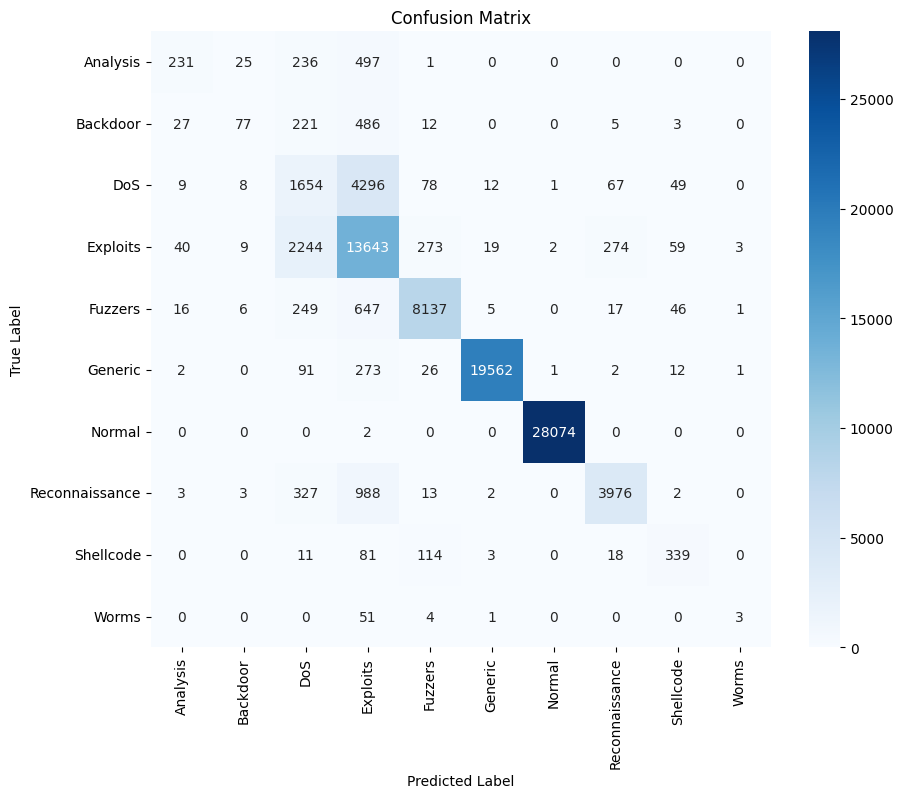

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()